In [158]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import defaultdict
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [159]:
np.random.seed(500)

In [160]:
# Load the data
Corpus = pd.read_csv('data/data.csv')

In [161]:
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  194 non-null    object
 1   fulltext  189 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [162]:
Corpus.head()

,category,fulltext
0,accountability,United Nations A/60/846/Add.6 Gener...
1,accountability,United Nations A/71/729 General Asse...
2,accountability,United Nations A/72/492 General Asse...
3,accountability,United Nations A/72/492/Add.2 Genera...
4,accountability,United Nations A/73/688 General Asse...


In [163]:
Corpus["category"].value_counts()

category
travel                  75
human resources         66
accountability          42
health and wellbeing    11
Name: count, dtype: int64

In [164]:
Corpus.isnull().sum()

category    0
fulltext    5
dtype: int64

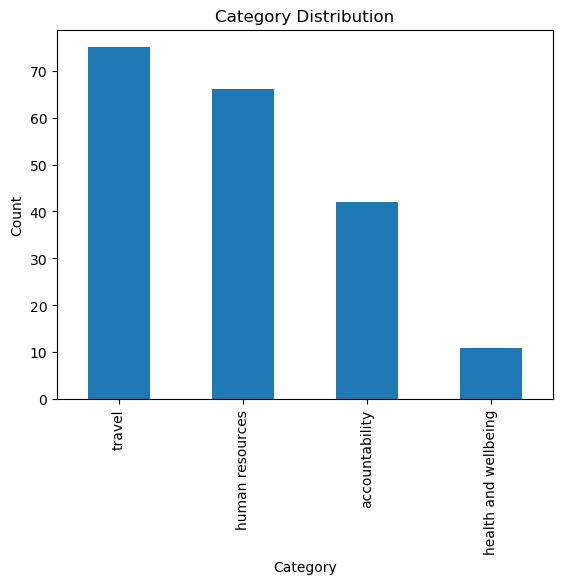

In [165]:
# category distribution
Corpus['category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Distribution')
plt.show()

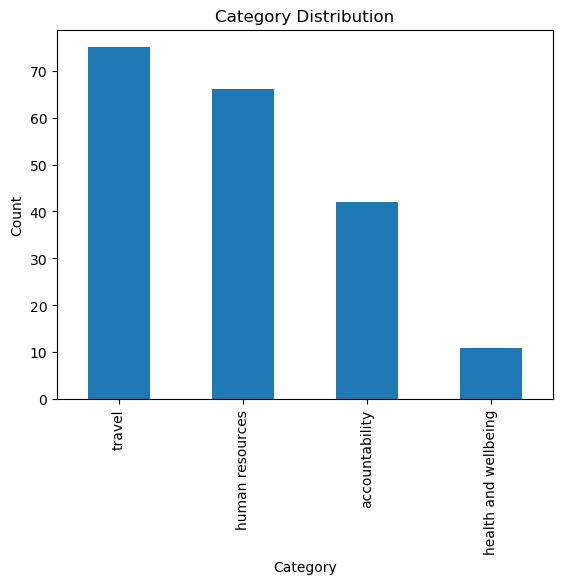

In [166]:
# category distribution
Corpus['category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Distribution')
plt.show()


### Data Pre-processing

1. Remove rows with blank values
2. Change all to lower case
3. Tokenization
4. Remove stop words
5. Remove non-alpha text
6. Word Lemmatization


In [167]:
Corpus.isnull().sum()

category    0
fulltext    5
dtype: int64

In [168]:
# Step 0: We only have 10 records with category health and wellbeing. We will remove these records since they are not enough to train the model.
Corpus = Corpus[Corpus['category'] != 'health and wellbeing']
# Step 1: Remove missing values
Corpus['fulltext'].dropna(inplace=True)
# Step 2: Change all the text to lower case
Corpus['fulltext'] = [entry.lower() if isinstance(entry, str) else '' for entry in Corpus['fulltext']]
# Step 3: Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['fulltext'] = [word_tokenize(entry) for entry in Corpus['fulltext']]
# Step 4: Remove stop words, non-alphabet and perfom word lemmatization
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['fulltext']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    Corpus.loc[index,'text_final'] = str(Final_words)
    
Corpus.head()

,category,fulltext,text_final
0,accountability,"[united, nations, a/60/846/add.6, general, ass...","['united', 'nation', 'general', 'assembly', 'd..."
1,accountability,"[united, nations, a/71/729, general, assembly,...","['united', 'nation', 'general', 'assembly', 'd..."
2,accountability,"[united, nations, a/72/492, general, assembly,...","['united', 'nation', 'general', 'assembly', 'd..."
3,accountability,"[united, nations, a/72/492/add.2, general, ass...","['united', 'nation', 'general', 'assembly', 'd..."
4,accountability,"[united, nations, a/73/688, general, assembly,...","['united', 'nation', 'general', 'assembly', 'd..."


In [169]:
Corpus.isnull().sum()

category      11
fulltext      11
text_final    11
dtype: int64

In [170]:
# Remove rows with empty fields
Corpus = Corpus.dropna()

In [171]:
Corpus.isnull().sum()

category      0
fulltext      0
text_final    0
dtype: int64

In [172]:
Corpus["category"].value_counts()

category
human resources    66
travel             64
accountability     42
Name: count, dtype: int64

### Prepare Train and Test Data

In [173]:
# Prepare test data
X_train, X_test, y_train, y_test = train_test_split(Corpus['text_final'], Corpus['category'], test_size=0.3)

In [174]:
X_train.head()

9      ['united', 'nation', 'secretariat', 'april', '...
138    ['united', 'nation', 'secretariat', 'march', '...
28     ['united', 'nation', 'secretariat', 'august', ...
37     ['united', 'nation', 'secretariat', 'december'...
1      ['united', 'nation', 'general', 'assembly', 'd...
Name: text_final, dtype: object

In [175]:
y_train.head()

9      accountability
138            travel
28     accountability
37     accountability
1      accountability
Name: category, dtype: object

### Encode category

In [176]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [177]:
y_test

array([2, 0, 2, 1, 2, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 0, 1, 2, 0, 2, 2, 0,
       0, 2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 2, 2, 0, 1, 0, 1,
       2, 1, 1, 2, 1, 1, 1, 2])

In [178]:
list(Encoder.transform(['accountability', 'human resources', 'travel']))
labels = [0, 1, 2]

In [179]:
list(Encoder.classes_)
target_names = ['accountability', 'human resources', 'travel']

### Using CountVectorizer: default and using best parameter

In [180]:
# Use CountVectorizer - Logistic Regression - Default
cvect_lgr_pipe = ''
cvect_lgr_default_acc = ''
   
cvect_lgr_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('lgr', LogisticRegression(max_iter=10000))])
cvect_lgr_pipe.fit(X_train, y_train)

print(cvect_lgr_pipe.named_steps)

cvect_lgr_default_acc = round((cvect_lgr_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Logistic Regression - Default - Accuracy: {cvect_lgr_default_acc}')

print(classification_report(y_test, cvect_lgr_pipe.predict(X_test), labels=labels, target_names=target_names))

{'cvect': CountVectorizer(), 'lgr': LogisticRegression(max_iter=10000)}
CountVectorizer - Logistic Regression - Default - Accuracy: 55.77
                 precision    recall  f1-score   support

 accountability       0.44      0.58      0.50        12
human resources       0.52      0.55      0.54        20
         travel       0.73      0.55      0.63        20

       accuracy                           0.56        52
      macro avg       0.56      0.56      0.56        52
   weighted avg       0.58      0.56      0.56        52



In [181]:
# Use CountVectorizer - Logistic Regression - Best
lgr_params = {'cvect__max_features': [100, 500, 1000, 2000],
         'lgr__C': [0.1, 1, 10, 100]}
cvect_lgr_grid = ''
cvect_lgr_best_acc = ''

cvect_lgr_grid = GridSearchCV(cvect_lgr_pipe, param_grid=lgr_params)
cvect_lgr_grid.fit(X_train, y_train)

print(cvect_lgr_grid.best_params_)

cvect_lgr_lgrbest_acc = round((cvect_lgr_grid.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Logistic Regression - Best - Accuracy: {cvect_lgr_lgrbest_acc}')

print(classification_report(y_test, cvect_lgr_grid.predict(X_test), labels=labels, target_names=target_names))

{'cvect__max_features': 1000, 'lgr__C': 0.1}
CountVectorizer - Logistic Regression - Best - Accuracy: 59.62
                 precision    recall  f1-score   support

 accountability       0.50      0.67      0.57        12
human resources       0.55      0.60      0.57        20
         travel       0.79      0.55      0.65        20

       accuracy                           0.60        52
      macro avg       0.61      0.61      0.60        52
   weighted avg       0.63      0.60      0.60        52



In [182]:
# Use CountVectorizer - Naive Bayes - Default
cvect_nb_pipe = ''
cvect_nb_default_acc = ''
   
cvect_nb_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('bayes', MultinomialNB())])
cvect_nb_pipe.fit(X_train, y_train)

print(cvect_nb_pipe.named_steps)

cvect_nb_default_acc = round((cvect_nb_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Naive Bayes - Default - Accuracy: {cvect_nb_default_acc}')

print(classification_report(y_test, cvect_nb_pipe.predict(X_test), labels=labels, target_names=target_names))


{'cvect': CountVectorizer(), 'bayes': MultinomialNB()}
CountVectorizer - Naive Bayes - Default - Accuracy: 76.92
                 precision    recall  f1-score   support

 accountability       0.67      0.83      0.74        12
human resources       0.75      0.60      0.67        20
         travel       0.86      0.90      0.88        20

       accuracy                           0.77        52
      macro avg       0.76      0.78      0.76        52
   weighted avg       0.77      0.77      0.77        52



In [183]:
# Use CountVectorizer - Naive Bayes - Best
nb_params = {'cvect__max_features': [100, 500, 1000, 2000],
         'bayes__alpha': [0.1, 1, 10, 100]}

cvect_nb_grid = ''
cvect_nb_best_acc = ''

cvect_nb_grid = GridSearchCV(cvect_nb_pipe, param_grid=nb_params)
cvect_nb_grid.fit(X_train, y_train)

print(cvect_nb_grid.best_params_)

cvect_nb_best_acc = round((cvect_nb_grid.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Naive Bayes - Best - Accuracy: {cvect_nb_best_acc}')

print(classification_report(y_test, cvect_nb_grid.predict(X_test), labels=labels, target_names=target_names))

{'bayes__alpha': 0.1, 'cvect__max_features': 2000}
CountVectorizer - Naive Bayes - Best - Accuracy: 76.92
                 precision    recall  f1-score   support

 accountability       0.67      0.83      0.74        12
human resources       0.75      0.60      0.67        20
         travel       0.86      0.90      0.88        20

       accuracy                           0.77        52
      macro avg       0.76      0.78      0.76        52
   weighted avg       0.77      0.77      0.77        52



In [184]:
# Use CountVectorizer - Support Vector Machine - Default
cvect_svm_pipe = ''
cvect_svm_default_acc = ''
   
cvect_svm_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('svc', SVC(probability=True))])
cvect_svm_pipe.fit(X_train, y_train)

print(cvect_svm_pipe.named_steps)

cvect_svm_default_acc = round((cvect_svm_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Support Vector Machine - Default - Accuracy: {cvect_svm_default_acc}')

print(classification_report(y_test, cvect_svm_pipe.predict(X_test), labels=labels, target_names=target_names))


{'cvect': CountVectorizer(), 'svc': SVC(probability=True)}
CountVectorizer - Support Vector Machine - Default - Accuracy: 50.0
                 precision    recall  f1-score   support

 accountability       0.71      0.42      0.53        12
human resources       0.43      0.90      0.58        20
         travel       1.00      0.15      0.26        20

       accuracy                           0.50        52
      macro avg       0.71      0.49      0.46        52
   weighted avg       0.71      0.50      0.45        52



In [185]:
# Use CountVectorizer - Support Vector Machine - Best
svm_params = {'cvect__max_features': [100, 500, 1000, 2000],
         'svc__C': [0.1, 1, 10, 100]}

cvect_svm_grid = ''
cvect_svm_best_acc = ''

cvect_svm_grid = GridSearchCV(cvect_svm_pipe, param_grid=svm_params)
cvect_svm_grid.fit(X_train, y_train)

print(cvect_svm_grid.best_params_)

cvect_svm_best_acc = round((cvect_svm_grid.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Support Vector Machine - Best - Accuracy: {cvect_svm_best_acc}')

print(classification_report(y_test, cvect_svm_grid.predict(X_test), labels=labels, target_names=target_names))

{'cvect__max_features': 2000, 'svc__C': 100}
CountVectorizer - Support Vector Machine - Best - Accuracy: 69.23
                 precision    recall  f1-score   support

 accountability       0.67      0.67      0.67        12
human resources       0.57      0.80      0.67        20
         travel       1.00      0.60      0.75        20

       accuracy                           0.69        52
      macro avg       0.75      0.69      0.69        52
   weighted avg       0.76      0.69      0.70        52



### Using TfidfVectorizer

In [186]:
# Use TfidVectorizer - Logistic Regression - Default
tvect_lgr_pipe = ''
tvect_lgr_default_acc = ''
   
tvect_lgr_pipe = Pipeline([('tvect', TfidfVectorizer()),
                       ('lgr', LogisticRegression(max_iter=10000))])
tvect_lgr_pipe.fit(X_train, y_train)

tvect_lgr_pipe.named_steps

tvect_lgr_default_acc = round((tvect_lgr_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - Logistic Regression - Default - Accuracy: {tvect_lgr_default_acc}')

print(classification_report(y_test, tvect_lgr_pipe.predict(X_test), labels=labels, target_names=target_names))


TfidVectorizer - Logistic Regression - Default - Accuracy: 75.0
                 precision    recall  f1-score   support

 accountability       0.73      0.92      0.81        12
human resources       0.68      0.65      0.67        20
         travel       0.83      0.75      0.79        20

       accuracy                           0.75        52
      macro avg       0.75      0.77      0.76        52
   weighted avg       0.75      0.75      0.75        52



In [187]:
# Use TfidVectorizer - Logistic Regression - Best
lgr_params = {'tvect__max_features': [100, 500, 1000, 2000],
         'lgr__C': [0.1, 1, 10, 100]}
tvect_lgr_grid = ''
tvect_lgr_best_acc = ''

tvect_lgr_grid = GridSearchCV(tvect_lgr_pipe, param_grid=lgr_params)
tvect_lgr_grid.fit(X_train, y_train)

print(tvect_lgr_grid.best_params_)

tvect_lgr_lgrbest_acc = round((tvect_lgr_grid.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Logistic Regression - Best - Accuracy: {tvect_lgr_lgrbest_acc}')

print(classification_report(y_test, tvect_lgr_grid.predict(X_test), labels=labels, target_names=target_names))

{'lgr__C': 100, 'tvect__max_features': 1000}
CountVectorizer - Logistic Regression - Best - Accuracy: 71.15
                 precision    recall  f1-score   support

 accountability       0.59      0.83      0.69        12
human resources       0.65      0.65      0.65        20
         travel       0.93      0.70      0.80        20

       accuracy                           0.71        52
      macro avg       0.72      0.73      0.71        52
   weighted avg       0.74      0.71      0.72        52



#### NB

In [188]:
# Use TfidVectorizer - Naive Bayes - Default
tvect_nb_pipe = ''
tvect_nb_default_acc = ''
   
tvect_nb_pipe = Pipeline([('tvect', TfidfVectorizer()),
                       ('bayes', MultinomialNB())])
tvect_nb_pipe.fit(X_train, y_train)

print(tvect_nb_pipe.named_steps)

tvect_nb_default_acc = round((tvect_nb_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - Naive Bayes - Default - Accuracy: {tvect_nb_default_acc}')

print(classification_report(y_test, tvect_nb_pipe.predict(X_test), labels=labels, target_names=target_names))

{'tvect': TfidfVectorizer(), 'bayes': MultinomialNB()}
TfidVectorizer - Naive Bayes - Default - Accuracy: 80.77
                 precision    recall  f1-score   support

 accountability       0.77      0.83      0.80        12
human resources       0.75      0.75      0.75        20
         travel       0.89      0.85      0.87        20

       accuracy                           0.81        52
      macro avg       0.80      0.81      0.81        52
   weighted avg       0.81      0.81      0.81        52



In [189]:
# Use TfidVectorizer - Naive Bayes - Best
nb_params = {'tvect__max_features': [100, 500, 1000, 2000],
         'bayes__alpha': [0.1, 1, 10, 100]}

tvect_nb_grid = ''
tvect_nb_best_acc = ''

tvect_nb_grid = GridSearchCV(tvect_nb_pipe, param_grid=nb_params)
tvect_nb_grid.fit(X_train, y_train)

print(tvect_nb_grid.best_params_)

tvect_nb_best_acc = round((tvect_nb_grid.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - Naive Bayes - Best - Accuracy: {tvect_nb_best_acc}')

print(classification_report(y_test, tvect_nb_grid.predict(X_test), labels=labels, target_names=target_names))


{'bayes__alpha': 0.1, 'tvect__max_features': 2000}
TfidVectorizer - Naive Bayes - Best - Accuracy: 76.92
                 precision    recall  f1-score   support

 accountability       0.71      1.00      0.83        12
human resources       0.75      0.60      0.67        20
         travel       0.84      0.80      0.82        20

       accuracy                           0.77        52
      macro avg       0.77      0.80      0.77        52
   weighted avg       0.78      0.77      0.76        52



In [190]:
# Use TfidVectorizer - Support Vector Machine - Default
tvect_svm_pipe = ''
tvect_svm_default_acc = ''
   
tvect_svm_pipe = Pipeline([('tvect', TfidfVectorizer()),
                       ('svc', SVC(probability=True))])
tvect_svm_pipe.fit(X_train, y_train)

print(tvect_svm_pipe.named_steps)

tvect_svm_default_acc = round((tvect_svm_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - SVM - Default Accuracy: {cvect_svm_default_acc}')

print(classification_report(y_test, tvect_svm_pipe.predict(X_test), labels=labels, target_names=target_names))


{'tvect': TfidfVectorizer(), 'svc': SVC(probability=True)}
TfidVectorizer - SVM - Default Accuracy: 50.0
                 precision    recall  f1-score   support

 accountability       0.62      0.83      0.71        12
human resources       0.68      0.65      0.67        20
         travel       0.88      0.75      0.81        20

       accuracy                           0.73        52
      macro avg       0.73      0.74      0.73        52
   weighted avg       0.75      0.73      0.73        52



In [191]:
# Use TfidVectorizer - Support Vector Machine - Best
svm_params = {'tvect__max_features': [100, 500, 1000, 2000],
         'svc__C': [0.1, 1, 10, 100]}

tvect_svm_grid = ''
tvect_svm_best_acc = ''

tvect_svm_grid = GridSearchCV(tvect_svm_pipe, param_grid=svm_params)
tvect_svm_grid.fit(X_train, y_train)

print(tvect_svm_grid.best_params_)

tvect_svm_best_acc = round((tvect_svm_grid.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - Support Vector Machine - Best - Accuracy: {tvect_svm_best_acc}')

print(classification_report(y_test, tvect_svm_grid.predict(X_test), labels=labels, target_names=target_names))

{'svc__C': 10, 'tvect__max_features': 2000}
TfidVectorizer - Support Vector Machine - Best - Accuracy: 76.92
                 precision    recall  f1-score   support

 accountability       0.63      1.00      0.77        12
human resources       0.76      0.65      0.70        20
         travel       0.94      0.75      0.83        20

       accuracy                           0.77        52
      macro avg       0.78      0.80      0.77        52
   weighted avg       0.80      0.77      0.77        52

